In [1]:
from skeletonization.skeletonizer import Skeletonizer
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skeletonization.bonetypes import common
from scipy import ndimage
import networkx as nx

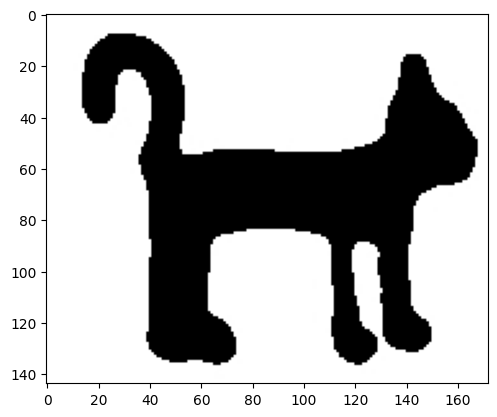

In [2]:
img = cv2.imread('cat_1_mask_classical.jpg')
img = ~img
plt.imshow(img)
plt.show()

In [3]:
skeletonizer = Skeletonizer(img)
skeleton = skeletonizer.skeletonize(30,3,10)

In [4]:
segmented = cv2.imread('cat_1_segmented_data.jpg',cv2.IMREAD_GRAYSCALE)
segmented = cv2.resize(segmented,(img.shape[1],img.shape[0]))
skeleton.identify(segmented)

In [5]:
joint_type_to_color = {
    common.JointType.LIMB : 'b',
    common.JointType.BODY : 'g',
    common.JointType.HEAD : 'r',
    common.JointType.WING : 'm',
    common.JointType.MIXED : 'c',
    common.JointType.NONE : 'y'
}

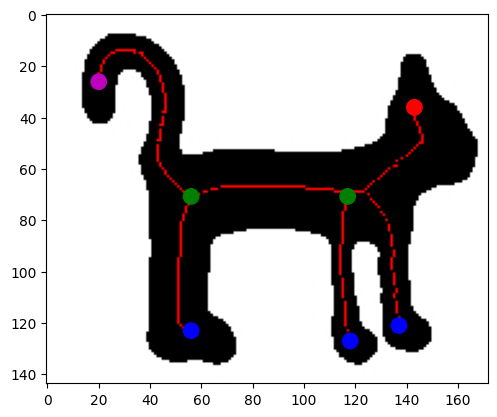

In [6]:
visiualize = np.copy(img)

for bone in skeleton.get_bones():
    for point in bone[1]:
        visiualize[int(point[1])][int(point[0])] = [255,0,0]

fig, ax = plt.subplots()
ax.imshow(visiualize)
for joint in skeleton.joints:
    circle = patches.Circle((joint.position[0], joint.position[1]),3,color=joint_type_to_color[joint.type])
    ax.add_patch(circle)
plt.show()

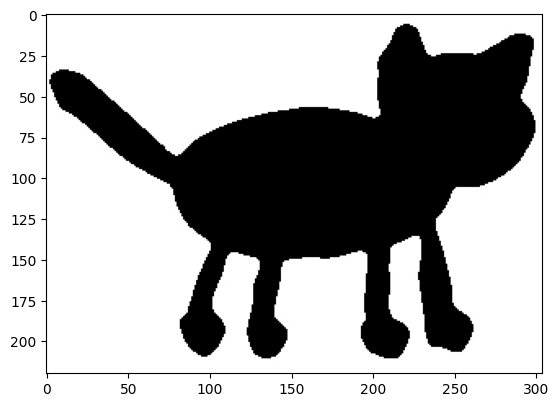

In [7]:
prototype_img = cv2.imread("cat_proto_mask.jpg",cv2.IMREAD_COLOR)
prototype_img = ~prototype_img
plt.imshow(prototype_img)
plt.show()

In [8]:
proto_skeletonizer = Skeletonizer(prototype_img)
proto_skeleton = proto_skeletonizer.skeletonize(30,3,10)
proto_segmented = cv2.imread('cat_proto_segment.jpg',cv2.IMREAD_GRAYSCALE)
proto_segmented = cv2.resize(proto_segmented,(prototype_img.shape[1],prototype_img.shape[0]))
proto_skeleton.identify(proto_segmented)

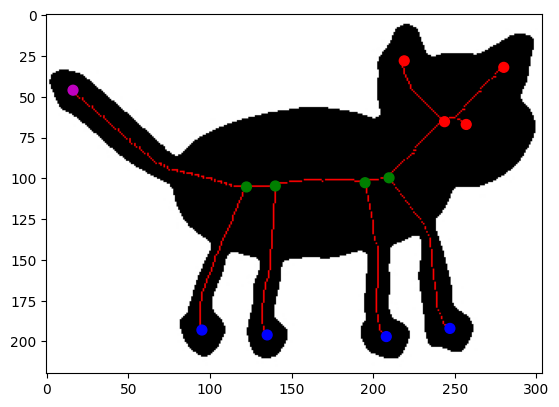

In [9]:
visiualize_proto = np.copy(prototype_img)

for bone in proto_skeleton.get_bones():
    for point in bone[1]:
        visiualize_proto[int(point[1])][int(point[0])] = [255,0,0]

fig, ax = plt.subplots()
ax.imshow(visiualize_proto)
for joint in proto_skeleton.joints:
    circle = patches.Circle((joint.position[0], joint.position[1]),3,color=joint_type_to_color[joint.type])
    ax.add_patch(circle)
plt.show()

## Normalize skeletons

In [10]:
skeleton.normalize_positions()
proto_skeleton.normalize_positions()

In [11]:
subject_endpoints = skeleton.find_endpoints()
prototype_endpoints = proto_skeleton.find_endpoints()

print(f"Subject Endpoints: {subject_endpoints} | Prototype Endpoints: {prototype_endpoints}")

ordered_subject_endpoints = skeleton.order_endpoints(subject_endpoints)
ordered_prototype_endpoints = proto_skeleton.order_endpoints(prototype_endpoints)

print(f"Ordered Subject Endpoints: {ordered_subject_endpoints} | Ordered Prototype Endpoints: {ordered_prototype_endpoints}")

Subject Endpoints: [2, 3, 4, 5, 6] | Prototype Endpoints: [4, 5, 6, 7, 8, 9, 11, 12]
Ordered Subject Endpoints: [6, 2, 3, 4, 5] | Ordered Prototype Endpoints: [12, 4, 5, 6, 7, 8, 9, 11]


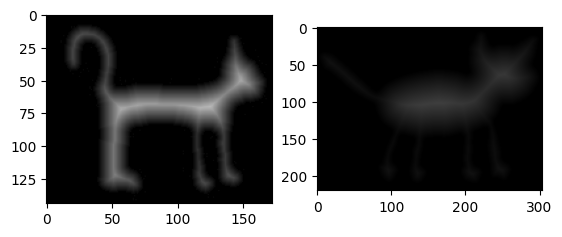

In [12]:
subject_distance_transfrom = ndimage.distance_transform_edt(~img)
subject_normalizer_dt = 1 / (sum(sum(subject_distance_transfrom))/2)
normalized_subject_distance_transform = subject_distance_transfrom * subject_normalizer_dt

prototype_distance_transfrom = ndimage.distance_transform_edt(~prototype_img)
prototype_normalizer_dt = 1 / (sum(sum(prototype_distance_transfrom))/2)
normalized_prototype_distance_transform = prototype_distance_transfrom * prototype_normalizer_dt

fig, axs = plt.subplots(ncols=2)

axs[0].imshow(normalized_subject_distance_transform*1000)
axs[1].imshow(normalized_prototype_distance_transform*1000)
plt.show()

## Get graph representation of skeletons

In [13]:
subject_graph = skeleton.to_network_x()
subject_graph.remove_edges_from(nx.selfloop_edges(subject_graph))

prototype_graph = proto_skeleton.to_network_x()
prototype_graph.remove_edges_from(nx.selfloop_edges(prototype_graph))

In [14]:
print(subject_graph,prototype_graph)

Graph with 7 nodes and 6 edges Graph with 13 nodes and 12 edges


In [17]:
for u in ordered_subject_endpoints:
    for v in ordered_subject_endpoints:
        if u == v:
            continue
        path = nx.shortest_path(subject_graph, u, v)
        print(f"Path from joint {u} to joint {v}:", path)

Path from joint 6 to joint 2: [6, 0, 1, 2]
Path from joint 6 to joint 3: [6, 0, 1, 3]
Path from joint 6 to joint 4: [6, 0, 1, 4]
Path from joint 6 to joint 5: [6, 0, 5]
Path from joint 2 to joint 6: [2, 1, 0, 6]
Path from joint 2 to joint 3: [2, 1, 3]
Path from joint 2 to joint 4: [2, 1, 4]
Path from joint 2 to joint 5: [2, 1, 0, 5]
Path from joint 3 to joint 6: [3, 1, 0, 6]
Path from joint 3 to joint 2: [3, 1, 2]
Path from joint 3 to joint 4: [3, 1, 4]
Path from joint 3 to joint 5: [3, 1, 0, 5]
Path from joint 4 to joint 6: [4, 1, 0, 6]
Path from joint 4 to joint 2: [4, 1, 2]
Path from joint 4 to joint 3: [4, 1, 3]
Path from joint 4 to joint 5: [4, 1, 0, 5]
Path from joint 5 to joint 6: [5, 0, 6]
Path from joint 5 to joint 2: [5, 0, 1, 2]
Path from joint 5 to joint 3: [5, 0, 1, 3]
Path from joint 5 to joint 4: [5, 0, 1, 4]
